ERROR: Could not find a version that satisfies the requirement keras.preprocessing.sequence (from versions: none)
ERROR: No matching distribution found for keras.preprocessing.sequence


In [8]:
import pickle
import numpy as np
from tensorflow.keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding
from keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM
import matplotlib.pyplot as plt

In [10]:
with open('/content/drive/MyDrive/AI And DataScience/PlotMyData Projects/train_qa-220120-145526.txt','rb')as fp:
  train_data=pickle.load(fp)

In [11]:
with open('/content/drive/MyDrive/AI And DataScience/PlotMyData Projects/test_qa-220120-145430.txt','rb')as fp:
  test_data=pickle.load(fp)


In [12]:
#Setup vocablurary
vocab=set()
all_data=train_data+test_data
for story,question,answer in all_data:
  vocab=vocab.union(set(story))
  vocab=vocab.union(set(question))
vocab.add('yes')
vocab.add('no')
vocab_len=len(vocab)+1
#vocab_len

In [13]:
max_sty_len=max([len(data[0])for data in all_data])
max_que_len=max([len(data[1])for data in all_data])

In [14]:
tokenizer=Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)
tokenizer.word_index

{'moved': 1,
 'john': 2,
 'sandra': 3,
 'took': 4,
 'up': 5,
 '.': 6,
 'office': 7,
 'travelled': 8,
 'milk': 9,
 'discarded': 10,
 'hallway': 11,
 'journeyed': 12,
 '?': 13,
 'garden': 14,
 'there': 15,
 'picked': 16,
 'went': 17,
 'grabbed': 18,
 'bedroom': 19,
 'bathroom': 20,
 'is': 21,
 'left': 22,
 'dropped': 23,
 'daniel': 24,
 'got': 25,
 'down': 26,
 'in': 27,
 'football': 28,
 'no': 29,
 'the': 30,
 'put': 31,
 'yes': 32,
 'to': 33,
 'kitchen': 34,
 'back': 35,
 'apple': 36,
 'mary': 37}

In [15]:
train_story_text=[]
train_question_text=[]
train_answer=[]
for story,question,answer in train_data:
  train_story_text.append(story)
  train_question_text.append(question)
train_story_seq=tokenizer.texts_to_sequences(train_story_text)
#len(train_story_text)
#len(train_story_seq)

In [16]:
def vectorize_stry(data,word_index=tokenizer.word_index,max_sty_len=max_sty_len,max_que_len=max_que_len):
  X=[]
  Xq=[]
  Y=[]
  for story,query,answer in data:
    x=[word_index[word.lower()] for word in story]
    xq=[word_index[word.lower()] for word in query]
    y=np.zeros(len(word_index)+1)
    y[word_index[answer]]=1

    X.append(x)
    Xq.append(xq)
    Y.append(y)

  return(pad_sequences(X,maxlen=max_sty_len),
         pad_sequences(Xq,maxlen=max_que_len),
         np.array(Y))

In [17]:
inputs_train,query_train,answer_train=vectorize_stry(train_data)
inputs_test,query_test,answer_test=vectorize_stry(test_data)

In [18]:
input_seq=Input((max_sty_len,))
question=Input((max_que_len,))


In [19]:
input_encoder_m=Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len,output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [20]:
input_encoder_c=Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len,output_dim=max_que_len))
input_encoder_c.add(Dropout(0.3))

In [21]:
question_encoder=Sequential()
question_encoder.add(Embedding(input_dim=vocab_len,output_dim=64,input_length=max_que_len))
question_encoder.add(Dropout(0.3))

In [22]:
input_encoded_m=input_encoder_m(input_seq)
input_encoded_c=input_encoder_c(input_seq)
question_encoded=question_encoder(question)

In [23]:
match=dot([input_encoded_m,question_encoded],axes=(2,2))
match=Activation('softmax')(match)

In [24]:
response=add([match,input_encoded_c])
response=Permute((2,1))(response)

In [25]:
answer=concatenate([response,question_encoded])
answer=LSTM(32)(answer)
answer=Dropout(0.5)(answer)
answer=Dense(vocab_len)(answer)
answer=Activation('softmax')(answer)
model=Model([input_seq,question],answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [26]:
history=model.fit([inputs_train,query_train],answer_train,
                  batch_size=32, epochs=150,
                  validation_data=([inputs_test,query_test],answer_test))

Epoch 1/150
313/313 [==============================] - 11s 25ms/step - loss: 0.8934 - accuracy: 0.5011 - val_loss: 0.6958 - val_accuracy: 0.4970
Epoch 2/150
313/313 [==============================] - 6s 19ms/step - loss: 0.7053 - accuracy: 0.4921 - val_loss: 0.6946 - val_accuracy: 0.5030
Epoch 3/150
313/313 [==============================] - 6s 19ms/step - loss: 0.6970 - accuracy: 0.5002 - val_loss: 0.6936 - val_accuracy: 0.4970
Epoch 4/150
313/313 [==============================] - 7s 22ms/step - loss: 0.6968 - accuracy: 0.5038 - val_loss: 0.6947 - val_accuracy: 0.4970
Epoch 5/150
313/313 [==============================] - 8s 27ms/step - loss: 0.6950 - accuracy: 0.4986 - val_loss: 0.6951 - val_accuracy: 0.4970
Epoch 6/150
313/313 [==============================] - 7s 22ms/step - loss: 0.6957 - accuracy: 0.4981 - val_loss: 0.6941 - val_accuracy: 0.5030
Epoch 7/150
313/313 [==============================] - 6s 19ms/step - loss: 0.6953 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 0, 'epochs')

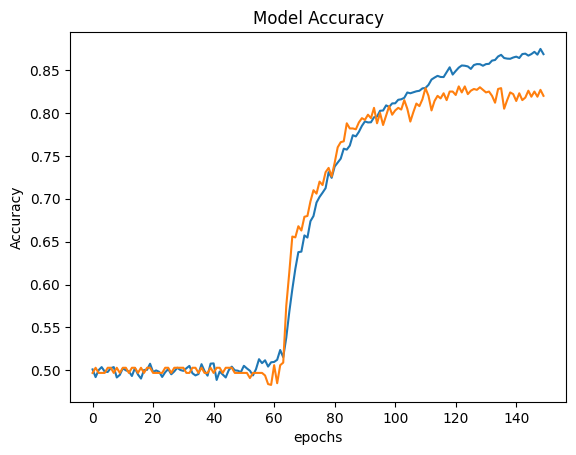

In [27]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epochs")

In [28]:
model.save("chatbot")

In [29]:
model.load_weights("/content/chatbot")
predict_result=model.predict(([inputs_test,query_test]))
val_max=np.argmax(predict_result[0])
for key,val in tokenizer.word_index.items():
  if val==val_max:
    k=key
print("predicted Answer is ",k)
print("Probability of certainity ",predict_result[0][val_max])

32/32 [==============================] - 1s 5ms/step
predicted Answer is  no
Probability of certainity  0.9851777


In [30]:
story="John is in the hallway . Sandra went to office ."
story.split()
my_q="Is John in the office ?"
my_q.split()
mydata=[(story.split(),my_q.split(),'no')]
my_story,my_que,my_ans=vectorize_stry(mydata)
pred_results=model.predict(([my_story,my_que]))
val_max=np.argmax(predict_result[0])
for key,val in tokenizer.word_index.items():
  if val==val_max:
    k=key
print("predicted Answer is ",k)
print("Probability of certainity ",predict_result[0][val_max])

1/1 [==============================] - 0s 26ms/step
predicted Answer is  no
Probability of certainity  0.9851777
